# Import and Loss

In [1]:
import sys 
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import *
from utils_test import *
from datas import *
from set_train import *
from models.Transformers import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
short = False
stock_symbol, end_date, num_class, batch_size, init, fp16_training, num_epochs, lr = set_train()
model = TransformerEncoderDecoder(num_class=num_class).to(device)
Model = model.model_type

### Loss Result

3.5290496349334717


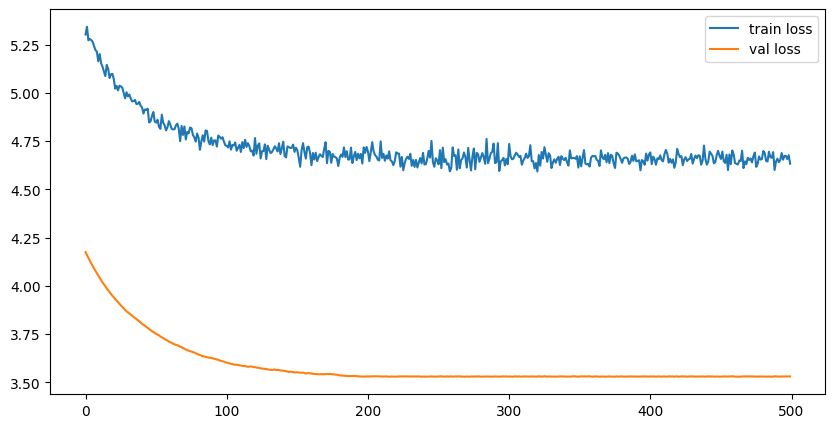

In [2]:
with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_LastTrainInfo.pk', 'rb') as f:
    infos = pickle.load(f)
    print(infos['min val loss'])

with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_TrainValHistLoss.pk', 'rb') as f:
    results = pickle.load(f)
    train_loss = results['train']
    val_loss = results['valid']
    
with open('Model_Result/min_loss.json', 'a') as file:
    import json
    json.dump({f'{Model}_class{num_class}_{stock_symbol}': infos['min val loss']}, file)
    file.write('\n')
    
plt.figure(figsize=(10, 5))
plt.plot(train_loss[:], label='train loss')
plt.plot(val_loss[:], label='val loss')
plt.legend()
plt.savefig(f'Model_Result/{Model}_class{num_class}_{stock_symbol.split(".")[0]}_loss')
plt.show()


### Data

In [3]:
# Data
trainloader, validloader, testloader, test_date, df, src = data(stock=stock_symbol, num_class=num_class, batch_size=batch_size)

src = src.permute(0, 2, 1).to(device)
x_valid = [x for x, y in validloader]
x_valid = torch.cat(x_valid, dim = 0)
for x, y in testloader:
    print(x.shape)
    break

100%|██████████| 2967/2967 [00:02<00:00, 1088.74it/s]

x_train_len: 2638, valid_len: 160, test_len: 160
torch.Size([160, 6, 10])


### Backtest 

In [4]:
def backtest_plot(normalize=False):    
    # Prediction
    model.load_state_dict(torch.load(f'Model_Result/{Model}_class{num_class}_{stock_symbol}_best_model.pt'))
    model.eval() 
    """
    model.load_state_dict(torch.load(f'Temp/{Model}_class{num_class}_{stock_symbol}_checkpoint_LastTrainModel.pt'))
    """   
    y_pred, _, acc = test_encoderdecoder(model, src, testloader)
    prediction = pd.DataFrame(y_pred.detach().cpu().numpy())
        
    # Scaling with predicted valid set
    if normalize:
        y_train_pred, _, acc = test_encoderdecoder(model, src, validloader)
        scaler = StandardScaler()
        scaler.fit(y_train_pred.detach().cpu().numpy())
        prediction = pd.DataFrame(scaler.transform(prediction))
    
    # Column name
    if num_class == 1:
        prediction.columns = ['pred_doc_1']
    else:
        prediction.columns = ['pred_do_1', 'pred_dc_1']

    # Merge on date. 
    #   In Encoder Decoder need to ignore the last batch if last batch's batch size != batch_size
    #   so use date_test[:len(prediction)]
    prediction['Date'] = test_date[:len(prediction)]
    true_and_pred = pd.merge(df.reset_index(), prediction, on = 'Date', how = 'left')   
    true_and_pred['Close'] = true_and_pred['Close_origin'] # Close is normalised while use Close in training, set Close to original
    
    
    # Backtest 
    #   Get the predicted doc_1. 
    #   If class == 1 the the y_pred is the doc_1
    """
    NOTE:
    1. Use today's data predict tmr's
    2. y is y * 100. /= 100 here
    3. For encoder-only and encoder-decoder since the second one need to drop last, 
    buy hold would not be the same
    """
    asset = 1
    asset_buyhold = 1
    asset_list = []
    thres = 0 if normalize else 0.00
    
    if num_class == 1:        
        df_backtest = true_and_pred[['Close', 'pred_doc_1', 'doc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        for index, (c, pred, true) in df_backtest.iterrows():
            if pred > thres:
                asset *= (1 + true)
            if short and pred < -thres:
                asset *= (1 - true)
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        # print(f'Buy Hold last asset: {asset_buyhold}')
            
    if num_class == 2:
        true_and_pred['pred_o'] = (true_and_pred['Open'] * (1 + true_and_pred['pred_do_1']))
        true_and_pred['pred_c'] = (true_and_pred['Close'] * (1 + true_and_pred['pred_dc_1']))
        true_and_pred['pred_doc_1'] = \
            (true_and_pred['pred_c'] - true_and_pred['pred_o'])/true_and_pred['pred_o']
        true_and_pred['doc_1'] /= 100
        true_and_pred['pred_doc_1'] /= 100
        df_backtest = true_and_pred[['Open', 'Close', 'doc_1', 'pred_doc_1', 'pred_do_1', 'pred_dc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        for index, (o, c, true, pred, _, _) in df_backtest.iterrows():
            if pred > thres:
                asset *= (1 + true)   
            if short and pred < -thres:
                asset *= (1 - true)   
            asset_buyhold *= (1 + true)
            asset_list.append(asset)

    # print(f'Accuracy: {acc}')
    print(f'Asset: {asset}')
    plt.plot(asset_list, label = 'model')
    plt.plot(df_backtest.reset_index()['Close']/df_backtest['Close'].iloc[0], label = 'buy hold')
    plt.legend()
    plt.savefig(f'Model_Result/{Model}_class{num_class}_{stock_symbol.split(".")[0]}_backtest')
    return y_pred, df_backtest

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Asset: 1.2200576947745625


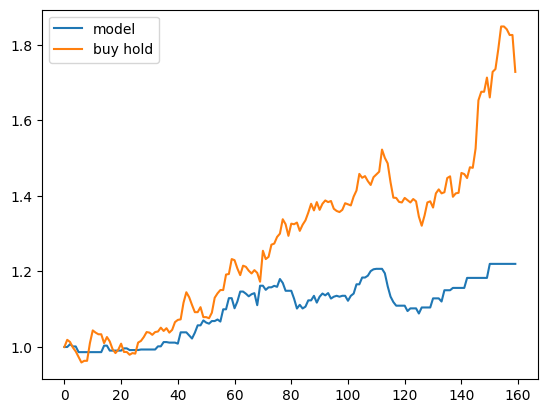

In [5]:
y_pred, df_b = backtest_plot(False)
torch.cuda.empty_cache()

In [6]:
y_pred

tensor([[ 4.1283e-01,  5.8431e-02],
        [ 6.1885e-01,  4.4589e-02],
        [-1.7474e-01,  5.9222e-02],
        [-5.2363e-01,  1.5197e-02],
        [ 4.0842e-01,  4.6427e-02],
        [-7.6091e-04,  2.2209e-02],
        [ 3.5132e-02,  4.7887e-02],
        [ 2.8791e-01,  4.7500e-02],
        [ 7.2523e-02,  6.0962e-02],
        [ 1.4202e+00, -4.1848e-02],
        [ 1.1179e+00,  2.7341e-02],
        [ 2.8867e-01,  2.7925e-02],
        [ 2.1369e-01,  2.8453e-02],
        [ 3.0257e-01,  4.2890e-02],
        [-4.5729e-01,  6.4820e-02],
        [ 3.6811e-01,  3.0602e-02],
        [-2.0360e-01,  3.0022e-02],
        [-2.2045e-01, -7.0079e-03],
        [ 9.9713e-02,  8.7780e-03],
        [ 5.5944e-01,  3.9649e-02],
        [ 3.9768e-01,  4.5220e-02],
        [-5.1311e-01,  2.8322e-02],
        [ 6.3102e-02,  2.8093e-02],
        [-5.0806e-02,  2.4493e-02],
        [ 5.7161e-01,  4.2708e-02],
        [ 2.4499e-01,  4.1409e-02],
        [ 7.5214e-01,  1.6109e-02],
        [-3.0071e-02,  5.155

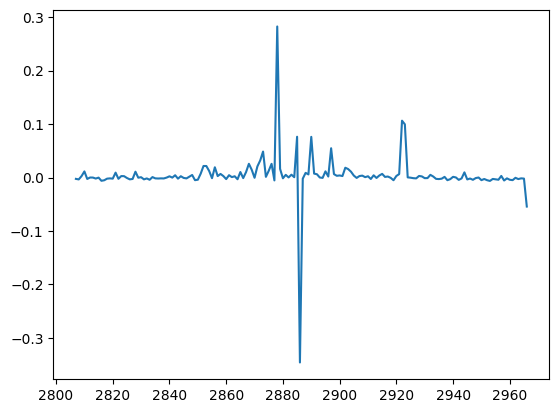

In [7]:
plt.plot(df_b['pred_doc_1'])

In [8]:
df_b.Close.iloc[-1]/df_b.Close.iloc[0]

1.728362785931918

In [9]:
stock_symbol.split('.')[0]

'2454'